In [ ]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

# The New York Social Graph


> Oct.2018, by Serena Ren based on TDI miniproject

[New York Social Diary](http://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural social graph for New York's social elite.  Take a look at this page of a recent [run-of-the-mill holiday party](http://www.newyorksocialdiary.com/party-pictures/2014/holiday-dinners-and-doers).

For this project, assemble the social graph from photo captions for parties dated Jan. 1, 2016, and after. For people appearing in a photo together, they are connected. Using the graph, we can draw implications of the social network in New York. 

The project will be have several phases:
1. Get a list of all the photo pages to be analyzed.
2. Parse all of the captions on a sample page.
3. Parse all of the captions on all pages, and assemble the graph.
4. Draw conclusions.

## Phase One


The first step is to crawl the data.  We want photos from parties on or after Jan 1st, 2016.  Go to the [Party Pictures Archive](http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.  We want to get the url for each party page, along with its date.

In [2]:
import requests  # to download the HTML pages
import dill
from bs4 import BeautifulSoup   # to process the HTML
from datetime import datetime

Start by getting the [first page](http://www.newyorksocialdiary.com/party-pictures).

In [3]:
url= "http://www.newyorksocialdiary.com/party-pictures"
page = requests.get(url, params={"search_api_views_fulltext": ""})
print page.url
page.text[:1000] + "..."

http://www.newyorksocialdiary.com/party-pictures?search_api_views_fulltext=


u'<!DOCTYPE html>\n  <!--[if IEMobile 7]><html class="no-js ie iem7" lang="en" dir="ltr"><![endif]-->\n  <!--[if lte IE 6]><html class="no-js ie lt-ie9 lt-ie8 lt-ie7" lang="en" dir="ltr"><![endif]-->\n  <!--[if (IE 7)&(!IEMobile)]><html class="no-js ie lt-ie9 lt-ie8" lang="en" dir="ltr"><![endif]-->\n  <!--[if IE 8]><html class="no-js ie lt-ie9" lang="en" dir="ltr"><![endif]-->\n  <!--[if (gte IE 9)|(gt IEMobile 7)]><html class="no-js ie" lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#"><![endif]-->\n  <!--[if !IE]><!--><html class="no-js" lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#"><!--<![endif]-->\n<he

Now, we process the text of the page with BeautifulSoup.

In [4]:
soup = BeautifulSoup(page.text, "lxml")

This page has links to 50 party pages. Look at the structure of the page and determine how to isolate those links. Use browser's developer tools (usually `Cmd`-`Option`-`I` on Mac, `Ctrl`-`Shift`-`I` on others)to explore the structure of the HTML page.

Once a pattern is found, use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) or [find_all](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) methods to get those elements.

In [5]:
tech_divs = soup.select('div.views-row')

In [6]:
import pandas as pd
df = pd.DataFrame(tech_divs)

In [9]:
from collections import namedtuple
Basic = namedtuple('Basic','url, date')
def td_info(td):
    la = td.select('a')
    ls = td.select('span')
    return Basic(url=la[0]['href'], date=ls[3].text)
links = filter(None, [td_info(td) for td in tech_divs])

There should be 50 per page.

In [8]:
assert len(links) == 50

Take a look at that first link. Extract the URL of the link, as well as the date. Use `datetime.strptime`. 

In [10]:
link = links[0]
print(link)
# Check that the title and date match what you see visually.

Basic(url='/party-pictures/2018/taking-center-stage', date=u'Tuesday, October 2, 2018')


For purposes of code reuse, put the logic into a function. Take the link element and return the URL and date parsed from it.

In [11]:
def get_link_date(el):
    url = str(el[0])
    date = datetime.strptime(str(el[1]), '%A, %B %d, %Y') 
    return url, date

Write another function to parse all of the links on a page.  Make it take a Requests [Response](http://docs.python-requests.org/en/master/api/#requests.Response) object and do the BeautifulSoup parsing within it.

In [15]:
def get_links(response):
    soup = BeautifulSoup(response.text,"lxml")
    tech_divs = soup.select('div.views-row')
    return filter(None, [get_link_date(td_info(td)) for td in tech_divs])  # A list of URL, date pairs

In [16]:
data = get_links(page)
df = pd.DataFrame(data, columns=['url', 'date'])

If we run this on the previous response, we should get 50 pairs.

In [17]:
assert len(get_links(page))==50

But we only want parties with dates in 2015 and 2016.  Write a function to filter the list of dates to those at or after a cutoff. 

In [222]:
def filter_by_date(links, cutoff1=datetime(2017, 1, 1), cutoff2 =datetime(2015,1,1)):
    ll=[]
    for i in range(len(links)):
        if get_link_date(links[i])[1] >= cutoff2 and get_link_date(links[i])[1] < cutoff1 :
            ll.append(get_link_date(links[i]))  
        i+=1
    return ll  

In [ ]:
#!pip install requests-futures

Then get all of the party URLs. Use requests_futures.sessions to pull multiple requests at one time.

In [25]:
def get_page_args(i):
    return {"url": url,
            "params": {"search_api_views_fulltext": "", "page": i}}

In [28]:
from requests_futures.sessions import FuturesSession
session = FuturesSession(max_workers=5)
links2 = [link2 
         for future in [session.get(**get_page_args(i)) for i in xrange(32)]
         for link2 in get_links(future.result())]

In [231]:
df = pd.DataFrame(links2, columns=['url', 'date'])
link_list=df[df['date']<'2017-1-01']
link_list = link_list[link_list['date']>='2015-1-01']

In [232]:
len(link_list)  # We get 190 links

190

In [233]:
link_list

,url,date
191,/party-pictures/2016/advocacy-philanthropy-and...,2016-12-27
192,/party-pictures/2016/impacting-the-community,2016-12-19
193,/party-pictures/2016/celebrating-the-many-acco...,2016-12-16
194,/party-pictures/2016/pulse-of-the-city,2016-12-14
195,/party-pictures/2016/the-human-society,2016-12-12
196,/party-pictures/2016/the-intimacy-of-individua...,2016-12-09
197,/party-pictures/2016/tis-the-season,2016-12-07
198,/party-pictures/2016/to-support-educate-and-em...,2016-12-06
199,/party-pictures/2016/first-position,2016-12-02
200,/party-pictures/2016/coming-together,2016-12-01


In case we need to restart the notebook, save this information to a file using `dill`.

In [234]:
dill.dump(link_list, open('nysd-links.pkd', 'w'))

To restore the list, we can just load it from the file.  When the notebook is restarted, you can skip the code above and just run this command.

In [235]:
link_list = dill.load(open('nysd-links.pkd', 'r'))

## Histogram


Get the number of party pages for the sampled months (that is, month-year pair) in the data.  
Plot the histogram. Do you see any trends?

In [236]:
link_list['date2'] = link_list['date'].dt.strftime('%b-%Y')

In [237]:
link_list['date2'].value_counts().head()

Nov-2015    12
Aug-2016    11
Jun-2015    11
Oct-2016    11
Apr-2015    10
Name: date2, dtype: int64

In [238]:
freq = link_list['date2'].value_counts().to_frame()

In [239]:
freq['month-year']=freq.index
freq['date'] = freq['date2']
freq =freq.drop(['date2'], axis=1)
freq.head()

,month-year,date
Nov-2015,Nov-2015,12
Aug-2016,Aug-2016,11
Jun-2015,Jun-2015,11
Oct-2016,Oct-2016,11
Apr-2015,Apr-2015,10


In [46]:
import matplotlib.pyplot as plt

<Container object of 24 artists>

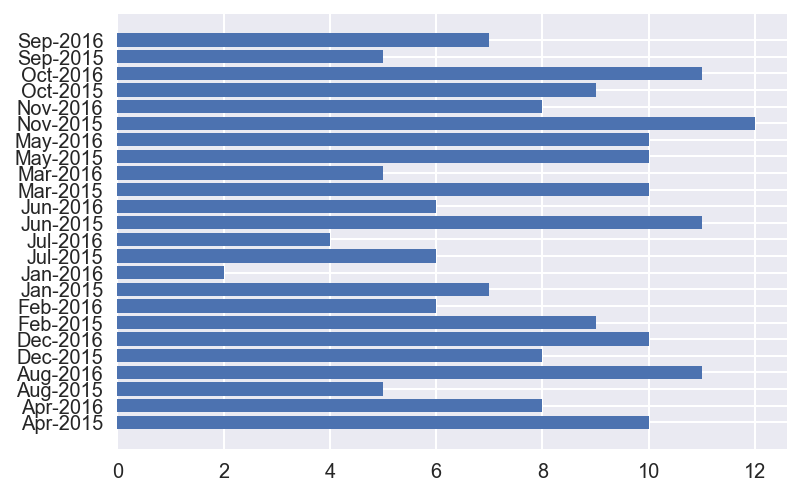

In [240]:
plt.barh(freq['month-year'],freq['date'] , align='center')

## Phase Two


We then need to get the names out of captions for a sample page.  Start with [Tuesday,Oct.2018 Taking Center Stage](http://www.newyorksocialdiary.com/party-pictures/2018/taking-center-stage).  There should be about 44 captions.

In [241]:
url= "http://www.newyorksocialdiary.com/party-pictures/2016/advocacy-philanthropy-and-community-leadership"
page = requests.get(url, params={"search_api_views_fulltext": ""})

In [242]:
soup = BeautifulSoup(page.text, "lxml")

In [243]:
import unicodedata
cap = soup.select('div.photocaption')
captions=[]
for i in range(len(cap)):
    captions.append(cap[i].text)

In [246]:
len(captions)

55

Then encapsulate this in a function. 

In [250]:
def get_captions(path):
    aurl = 'http://www.newyorksocialdiary.com'
    soup=BeautifulSoup(requests.get(aurl+path, params={"search_api_views_fulltext": ""}).text, "lxml")
    caps = soup.select('div.photocaption')
    #caps = soup.find_all(class_='photocaption')
    captions_path =[]
    for i in range(len(caps)):
        captions_path.append(caps[i].text)
    return captions_path


In [251]:
len(get_captions('/party-pictures/2016/advocacy-philanthropy-and-community-leadership'))

55

We can see that get_captions function return the same captions as before.

Now that we have some sample captions, then start parsing names out of those captions.  

  1. Some captions are not useful: they contain long narrative texts that explain the event.  A few heuristics include:
    - look for sentences (which have verbs) and as opposed to lists of nouns. For example, [`nltk` does part of speech tagging](http://www.nltk.org/book/ch05.html) but it is a little slow. There may also be heuristics that accomplish the same thing.
    - Similarly, spaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) could be useful here.
    - Look for commonly repeated threads.
    - Long captions are often not lists of people. 
  2. Separate the captions based on various forms of punctuation. Can consider using regex exclusively for name parsing.
  3. Couples are written as eg. "John and Mary Smith". Need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  

In [ ]:
#!pip install spacy
#!python -m spacy download en 

In [ ]:
import re
import spacy
nlp = spacy.load('en')

In [252]:
def get_names(caption):
#for i in range(len(captions)):    
    if caption.find('Honorees') != -1:
            caption = caption.replace('Honorees','')
    if caption.find('Honoree') != -1:
            caption = caption.replace('Honoree','')
    if caption.find('Honorable') != -1:
            caption = caption.replace('Honorable','')
    if caption.find('|') != -1:
            caption = caption.replace('|','')
    caption = re.sub('s{2,}', '', caption)
    caption = caption.lstrip()
    caption = caption.rstrip()
    caption = caption.strip('\n')

    doc = nlp(caption)
    result_caption = []
    for i, ent in enumerate(doc.ents):
        if ent.label_ == 'PERSON':
            name = ent.text
            #print(name)
            if len(ent.text.lstrip().split(' ')) ==1:
                if i+1 < len(doc.ents):
                    nextent = re.split('\s+', doc.ents[i+1].text.lstrip())
                    if len(nextent)>1:
                        newname = ent.text.lstrip()+' '+nextent[-1]
                       # print(newname)
                        name=newname
            result_caption.append(name)
    return result_caption

In [253]:
frames = []
for i in range(len(captions)):
    frames.append(pd.DataFrame(get_names(captions[i]), columns=['name']))
    #frames.append(pd.DataFrame(extract_entities(captions[i]), columns=['name', 'entity']))
df_entities = pd.concat(frames)

In [255]:
#Keep persons and drop duplicates
df_result = df_entities.drop_duplicates(subset=['name'])

In [256]:
df_result

,name
0,Alexander Smalls
1,Michael Feinstein
2,Cicely Tyson
3,Sandra L. Richards
4,Stan Lathan
5,Eric G. Pryor
0,Masquerade
0,Leon Robinson
0,Charles J. Hamilton
1,Pamela Carlton


In [257]:
# Sort names alphabetically
df_result['name'] = df_result['name'].apply(lambda x: x.strip())
df_result = df_result.sort_values('name')

/Users/serena/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [258]:
import unicodedata
df_result['str_name'] = df_result['name'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore'))

In [259]:
name_list = df_result['str_name'].tolist()
len(name_list)

99

In [260]:
import itertools

In [261]:
combinations=[]
for i in itertools.combinations(name_list, 2):
    combinations.append(i)
len(combinations)

4851

Think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a photo together, that is considered a link.  What we have described is more appropriately called an (undirected)
[multigraph](http://en.wikipedia.org/wiki/Multigraph) with no self-loops but this has an obvious analog in terms of an undirected [weighted graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph).  In this problem, we will analyze the social graph of the New York social elite. Use python's [`networkx`](https://networkx.github.io/) library.

In [310]:
# Write a function which extracts the edges from names in each caption
def get_edges(caption):
    df = pd.DataFrame(get_names(caption), columns=['name'])
    df['str_name'] = df['name'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore'))
    #names =df.loc[df['entity'] == 'PERSON']
    name_list = df['str_name'].tolist()
    name_list= [re.sub(' +',' ', i.replace('\n','').strip())for i in name_list]
    if len(name_list)>1:
        combination=[]
        for i in itertools.combinations(name_list, 2):
            combination.append(i)
        return combination
    else:
        return [('a', 'b')]

In [264]:
#Get edges in a list of captions
edges = []
for i in range(len(captions)):
    edges.append(get_edges(captions[i])) 

In [266]:
edges_clean = [i for i in edges if i !=[('a', 'b')] ]

In [267]:
edges_flat = [item for sublist in edges_clean for item in sublist]

In [268]:
# Create graph 
import networkx as nx
G = nx.Graph()
G.add_nodes_from(name_list)
G.add_edges_from(edges_flat)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 98
Number of edges: 99
Average degree:   2.0204


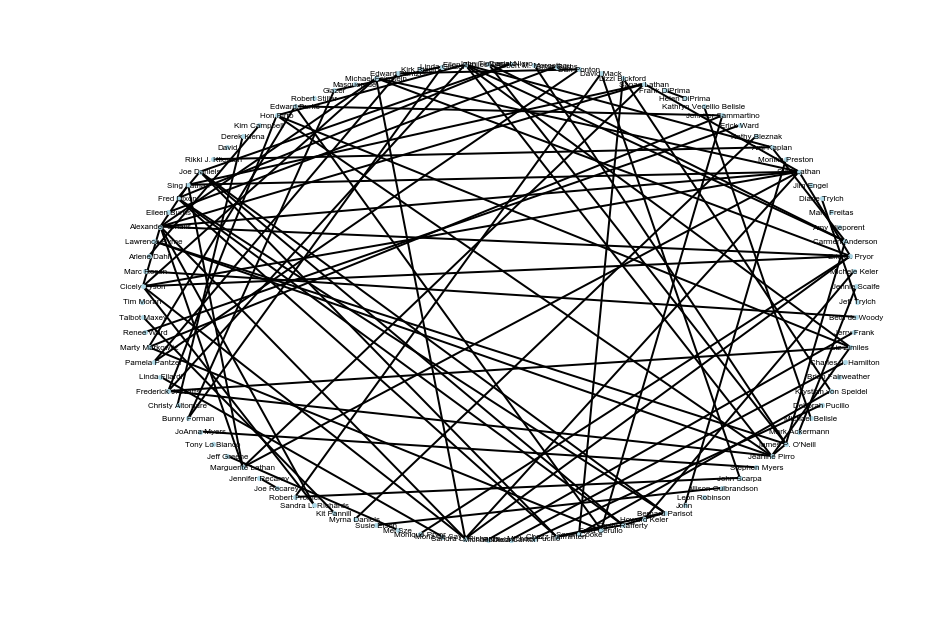

In [293]:
# Plot the celebrity network
import matplotlib.pyplot as plt
nx.draw_circular(G, node_color='lightblue', node_size=5, with_labels=True, font_size=4)

In [270]:
# Return the degree of each person, which indicates how many people each knows.
for i in G:
    print(i, len(G.edges(i)))

('Jeff Trylch', 1)
('Jennie Scaife', 1)
('Michele Keler', 1)
('Eric G. Pryor', 6)
('Carmen Anderson', 4)
('Amy Nieporent', 0)
('Mark Freitas', 0)
('Diane Trylch', 1)
('Jim Engel', 0)
('Stan Lathan', 8)
('Monika Preston', 1)
('Ami Kaplan', 3)
('Kathy Bleznak', 1)
('Erick Ward', 1)
('Jennifer Sammartino', 3)
('Kathryn Vecellio Belisle', 1)
('Helen DiPrima', 1)
('Frank DiPrima', 1)
('Sanaa Lathan', 4)
('Lizzi Bickford', 2)
('David Mack', 2)
('Dan Ponton', 2)
('Brian Burns', 1)
('Robert M. Morgethau', 1)
('Daniel Nigro', 2)
('John Timpanaro', 2)
('Ellen Zimiles', 6)
('Linda Glazer', 2)
('Kirk Blouin', 0)
('Edward Pantzer', 2)
('Michael Feinstein', 5)
('Masquerade', 0)
('Glazer', 2)
('Robert Stiller', 0)
('Edward Burke', 3)
('Hon Pirro', 4)
('Kim Campbell', 1)
('Derek Klena', 1)
('David', 0)
('Rikki J. Klieman', 1)
('Joe Daniels', 5)
('Sing Lathan', 4)
('Fred Dixon', 5)
('Eileen Burns', 1)
('Alexander Smalls', 9)
('Lawrence Byrne', 2)
('Arlene Dahl', 1)
('Marc Rosen', 1)
('Cicely Tyson', 6)

## Phase Three


Scrape all of the pages and construct networks.

In [301]:
captions_all=[]
for i in range(len(link_list)):
    captions_all.append(get_captions(link_list.iloc[i][0]))

In [311]:
l = [sum(v != 0 for v in i) for i in captions_all]

In [312]:
sum(l)

13080

In [313]:
frames = []
for c in range(len(captions_all)):
    for i in range(len(captions_all[c])):
        frames.append(pd.DataFrame(get_names(captions_all[c][i]), columns=['name']))
df_entities_all = pd.concat(frames)

In [314]:
#Keep persons and drop duplicates
df_p_allunique = df_entities_all.drop_duplicates(subset=['name'])

In [315]:
df_p_allunique['str_name'] = df_p_allunique['name'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore'))

/Users/serena/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [316]:
name_list = df_p_allunique['str_name'].tolist()

In [317]:
name_list= [re.sub(' +',' ', i.replace('\n','').strip())for i in name_list]

In [318]:
len(name_list)

17972

In [319]:
edges = []
for c in range(len(captions_all)):
    for i in range(len(captions_all[c])):
        edges.append(get_edges(captions_all[c][i])) 

In [320]:
edges_clean = [i for i in edges if i !=[('a', 'b')] ]
edges_flat = [item for sublist in edges_clean for item in sublist]

In [321]:
#import itertools  # itertools.combinations may be useful
import networkx as nx
import operator

In [322]:
G = nx.Graph()
G.add_nodes_from(name_list)
G.add_edges_from(edges_flat)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 17887
Number of edges: 27505
Average degree:   3.0754


From 2015 to 2016, we have more than 17000 people in the photographs and they have more than 27000 links.

With all the edges, we should be able to tell who tend to co-occur with each other, and presumably are "best" friends.

In [326]:
from collections import Counter
wG = nx.Graph()
edges = mG.edges()
weights = dict(Counter(edges))

In [328]:
for e in set(edges):
    wG.add_edge(e[0],e[1], weight = weights[e])

In [332]:
best_friends = wG.edges(data = True)

In [333]:
sort_friends = sorted(best_friends, key = lambda (u, v, d): d['weight'], reverse = True)[:110]

In [334]:
sort_friends

[('Barbara Tober', 'Donald Tober', {'weight': 20}),
 ('Peter Gregory', 'Jamee Gregory', {'weight': 13}),
 ('Mike Woods', 'Teresa Priolo', {'weight': 9}),
 ('Mike Woods', 'Javier Gomez', {'weight': 8}),
 ('Eleanora Kennedy', 'Anna Safir', {'weight': 8}),
 ('Scott Nelson', 'Alex Papachristidis', {'weight': 8}),
 ('Roric Tobin', 'Geoffrey Bradfield', {'weight': 7}),
 ('Bunny Williams', 'John Roelli', {'weight': 7}),
 ('Brian Fisher', 'Joanna Fisher', {'weight': 7}),
 ('Eminence Dolan', 'Timothy Michael Cardinal Dolan', {'weight': 7}),
 ('Michele Keler', 'Howard Keler', {'weight': 6}),
 ('Kenneth Fishel', 'Maria Fishel', {'weight': 6}),
 ('Lucy Fato', 'Victor Cruz', {'weight': 6}),
 ('George Ledes', 'Christine Schott Ledes', {'weight': 6}),
 ('Pamela Cohen', 'Nick Korniloff', {'weight': 6}),
 ('Mike Woods', 'Steve Lacy', {'weight': 6}),
 ('Susan Robbins', 'Richard Grausman', {'weight': 6}),
 ('Lori Gendelman', 'Bruce Gendelman', {'weight': 6}),
 ('Teresa Priolo', 'Javier Gomez', {'weight':

# Conclusion

The goal of this project is to practice web scraping and natural language processing(NLP) as well as forming networks.

From this project, we are able to shed some light on dicovering social elite connections using captions from pictures published online.

There is still room for improvement on name parsing accuracy and distributed processing to handle more information and larger networks.